In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/movielends-25m-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import pandas as pd, numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import os, glob

BASE = "/kaggle/input/movielens-25m-recsys/outputs/parquet"
parts = sorted(glob.glob(f"{BASE}/candidate_parts/candidates_part_*.parquet"))

candidates = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
item_features = pd.read_parquet(f"{BASE}/item_features.parquet")
user_genre    = pd.read_parquet(f"{BASE}/user_genre.parquet")
valid_label  = pd.read_parquet(f"{BASE}/valid_label.parquet")
test_label   = pd.read_parquet(f"{BASE}/test_label.parquet")

In [36]:
user_genre = user_genre.reset_index()
user_genre = user_genre.rename(columns={"index":"u"})
user_genre.head()

,u,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,0,0.0,0.524161,0.323198,0.076656,0.068369,0.258973,0.180245,0.006215,0.368777,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
1,1,0.0,0.228558,0.163256,0.065302,0.065302,0.391814,0.424465,0.000000,0.555070,...,0.000000,0.032651,0.032651,0.000000,0.097953,0.261209,0.163256,0.391814,0.032651,0.000000
2,2,0.0,0.234978,0.313304,0.274141,0.117489,0.078326,0.234978,0.000000,0.704934,...,0.000000,0.000000,0.000000,0.000000,0.039163,0.234978,0.078326,0.156652,0.117489,0.000000
3,3,0.0,0.493636,0.435561,0.319411,0.290374,0.319411,0.058075,0.000000,0.145187,...,0.000000,0.000000,0.319411,0.058075,0.029037,0.087112,0.319411,0.145187,0.058075,0.000000
4,4,0.0,0.406509,0.360489,0.340036,0.145730,0.329809,0.125276,0.017897,0.470425,...,0.002557,0.099710,0.092040,0.056246,0.074143,0.148286,0.276119,0.230099,0.061360,0.007670


In [37]:
# join features
df = (
    candidates
    .merge(item_features, on="i", how="left")
    .merge(user_genre,    on="u", how="left")
)
df.head()

,u,i,mf_score,movieId,title,item_count,item_mean,item_recency01,genre_(no genres listed)_x,genre_Action_x,...,genre_Film-Noir_y,genre_Horror_y,genre_IMAX_y,genre_Musical_y,genre_Mystery_y,genre_Romance_y,genre_Sci-Fi_y,genre_Thriller_y,genre_War_y,genre_Western_y
0,0,9585,3.833762,68237,Moon (2009),5554,4.023857,0.999982,0,0,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
1,0,11162,3.579858,88140,Captain America: The First Avenger (2011),5518,3.508789,0.999191,0,1,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
2,0,871,3.163824,1193,One Flew Over the Cuckoo's Nest (1975),8165,4.108512,0.999981,0,0,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
3,0,4742,3.079916,6365,"Matrix Reloaded, The (2003)",6630,3.423529,0.999364,0,1,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
4,0,3303,3.021434,4370,A.I. Artificial Intelligence (2001),3365,3.409956,0.999574,0,0,...,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359


In [38]:
df = df.rename(
    columns={c: c.replace("_y", "_user").replace("_x", "")
             for c in df.columns if c.endswith(("_x", "_y"))}
)

In [39]:
# genre similarity
genre_cols = [c for c in item_features.columns if c.startswith("genre_")]
ug = df[[c+"_user" for c in genre_cols]].to_numpy()
ig = df[genre_cols].to_numpy()
df["genre_sim"] = (ug * ig).sum(axis=1)

In [43]:
valid_label.head()

,u,i,rating,label
0,26197,13353,3.5,0
1,26197,9195,4.5,1
2,10102,7871,4.0,1
3,26197,361,4.5,1
4,26197,11711,3.5,0


## Attach Labels to Valid and Test set for training

In [41]:

valid_df = df[df["u"].isin(valid_label["u"])].merge(valid_label, on=["u","i"], how="left")
test_df  = df[df["u"].isin(test_label["u"])].merge(test_label,  on=["u","i"], how="left")

valid_df["label"] = (valid_df["rating"]>=4).astype(np.int8)
test_df["label"]  = (test_df["rating"]>=4).astype(np.int8)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


## LightGBM

In [45]:
features = ["mf_score","item_count","item_mean","item_recency01","genre_sim"]
train_data = lgb.Dataset(valid_df[features], label=valid_df["label"])
params = {"objective":"binary","metric":"auc","verbosity":-1}
gbm = lgb.train(params, train_data, num_boost_round=100)

## Evaluation

Precision@10 = 0.0863


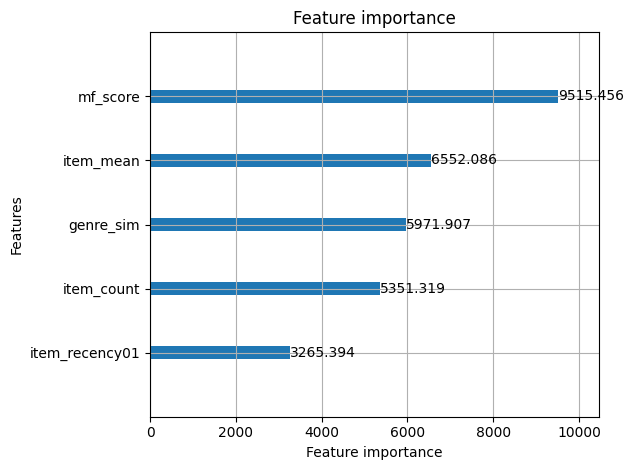

In [47]:
def precision_at_k(df, k=10):
    out = []
    for u, g in df.groupby("u"):
        g = g.sort_values("pred", ascending=False)[:k]
        rel = g["label"].to_numpy()
        out.append(rel.mean())
    return np.mean(out)

valid_df["pred"] = gbm.predict(valid_df[features])
p10 = precision_at_k(valid_df, k=10)
print(f"Precision@10 = {p10:.4f}")

lgb.plot_importance(gbm, importance_type="gain")
plt.tight_layout()
plt.show()